In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
#import plotnine 
#from plotnine import *
import yaml

## note: you may need to install some of these using !pip install
## note that bitdotio has psycopg2 as a dependency so you'll need to either do:
## !pip install psycopg2 or !pip install psycopg2-binary
## see this issue for installation notes: https://github.com/rebeccajohnson88/PPOL564_slides_activities/issues/65
import census
from census import Census
import us
from us import states
import bitdotio
import warnings
import json
warnings.filterwarnings("ignore")

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, "r") as file:
        return json.load(file)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# Prep work: obtain an API key for the US Census (the American Community Survey)

- Obtain a census API key from here: https://api.census.gov/data/key_signup.html 
- Place it in a credentials yaml file that also contains the API key with the key for the database API (shared on Canvas)
- Documentation here for the `census` package on establishing an API connection: https://github.com/datamade/census

# APIs and SQL (50 points)

# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity here: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/10_apis_naep_yelp_solutions.ipynb

We practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data at the state level and writing a wrapper function.
    
As a reminder, the documentation for the NAEP API is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link for writing queries is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# your code here
import pprint

params = {
    "type": "data",
    "subject": "mathematics",
    "grade": "8",
    "subscale": "MRPCM",
    "variable": "GENDER",
    "jurisdiction": "CA",
    "stattype": "MN:MN",
    "Year": "2015"
}

res_2015 = requests.get("https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx", params=params)
display(pd.read_json(json.dumps(res_2015.json()["result"])))

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0


Girls appear to have slightly higher scores than boys.

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as above but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to pull multiple years in the same query) in one query

In [3]:
# your code here
params = {
    "type": "data",
    "subject": "mathematics",
    "grade": "8",
    "subscale": "MRPCM",
    "variable": "GENDER",
    "jurisdiction": "CA",
    "stattype": "MN:MN",
    "Year": "2013, 2015, 2017, 2019"
}

res_2013_to_2019 = requests.get("https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx", params=params)
df = pd.read_json(json.dumps(res_2013_to_2019.json()["result"]))

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis at 270  and add informative labels

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


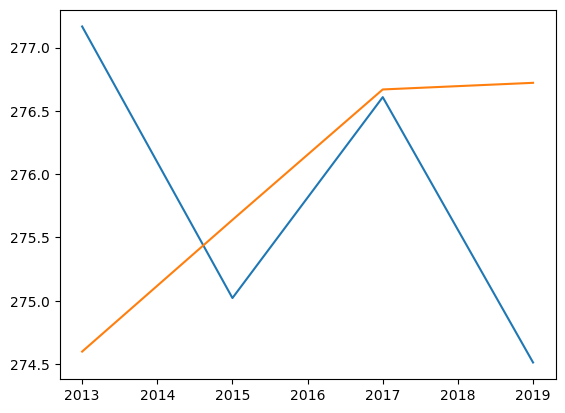

In [4]:
# your code here
import matplotlib.pyplot as plt

df
plt.plot(df[df.varValueLabel == "Male"].year, df[df.varValueLabel == "Male"].value)
plt.plot(df[df.varValueLabel == "Female"].year, df[df.varValueLabel == "Female"].value)
plt.show()

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if pulling one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [5]:
# your code here to define function
def construct_naep_query(year, place):
    params = {
        "type": "data",
        "subject": "mathematics",
        "grade": "8",
        "subscale": "MRPCM",
        "variable": "GENDER",
        "jurisdiction": place,
        "stattype": "MN:MN",
        "Year": ", ".join(list(map(str, year)))
    }
    return requests.get("https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx", params=params)

In [6]:
# your code here to execute function
assert(res_2015.json() == construct_naep_query([2015], "CA").json())
assert(res_2013_to_2019.json() == construct_naep_query([2013, 2015, 2017, 2019], "CA").json())

## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see solutions code for an example of try: except:)

- Execute the function on the query that pulls 2013, 2015, 2017, and 2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [7]:
# your code here
def process_naep_query(params):
    res = requests.get("https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx", params=params)
    try:
        return pd.read_json(json.dumps(res.json()["result"]))
    except:
        return("Data not found; check your parameters")

params = {
    "type": "data",
    "subject": "mathematics",
    "grade": "8",
    "subscale": "MRPCM",
    "variable": "GENDER",
    "jurisdiction": "CA",
    "stattype": "MN:MN",
    "Year": ", ".join(list(map(str, [2013, 2015, 2017, 2019])))
}

df = process_naep_query(params)
display(df)

params["jurisdiction"] = "ZZ"
df = process_naep_query(params)
print(df)

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


Data not found; check your parameters


# 2. Explore data using SQL queries (22 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

- Database name: `rebeccajohnson88/ppol564_classdb`
- Table name: `math_gencompare`



## 2.0 Load a creds file (0 points)

Load a creds file that contains the two credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

In [8]:
creds = load_creds("../../config.json")

## 2.1 Establish a connection to the database (1 point)

Note: if you get an error at this step, make sure you not only have bitdotio installed and imported but also its dependency psycopg2; we've also run into issues connecting on an unsecured (no password) wifi network so if you're on campus, try SaxaNet or eduroam

Note: for full credit, when initializing the bitdotio connection, make sure to use the API key from the creds file you read in eg:
`creds[class_database][api_key]` 

rather than hard-coding it in the code

In [79]:
# your code here
b = bitdotio.bitdotio(creds['CLASS_DB']['API_KEY'])
cnx = b.get_connection("rebeccajohnson88/ppol564_classdb")

## 2.2 Run a query to select all columns and the first 5 rows of the data to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [10]:
# your code here
df = pd.read_sql_query("select * from math_gencompare limit 5", cnx)
display(df)

,abbrev,fips,state,year,female,male,is_male_higher
0,AL,1,Alabama,2017,266.748589,269.820070,1
1,AL,1,Alabama,2019,270.473059,267.093325,0
2,AR,5,Arkansas,2013,278.381788,277.457662,0
3,AR,5,Arkansas,2015,274.793326,275.325959,1
4,AR,5,Arkansas,2017,273.139254,274.352754,1


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?



In [11]:
# your code here

display(pd.read_sql_query("select count(*) as rows, count(distinct state) as states, count(distinct year) as years from math_gencompare", cnx))

,rows,states,years
0,200,50,4


## 2.4 Construct a new variable in the table, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [12]:
# your code here
q = """
select *, case when male > female THEN 1
    else 0
end as is_male_higher
from math_gencompare
"""

df = pd.read_sql_query(q, cnx).head()
df.is_male_higher.mean()

is_male_higher    0.6
is_male_higher    0.6
dtype: float64

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states for that year where males have higher scores than females 

**B.** Interpret the results 

Hint: can either use subquery to construct the `is_male_higher` and use it or do it all in one query with a comparison; the `avg` command is useful

In [13]:
# your code here
q = """
select year, cast(count(state) as float)/50 as percentage
from math_gencompare
where male > female
group by year
"""

df = pd.read_sql_query(q, cnx).head()
display(df)

,year,percentage
0,2015,0.56
1,2017,0.58
2,2019,0.30
3,2013,0.62


## 2.5 group by state and find the percentage of years where male scores higher than females (4 points)

A. Write a query that (1) groups by state and (2) finds the percentage of years for that state where males have higher scores than females

B. Plot the results ordering the states from males higher all 4 years (prop = 1 or percent = 100%) to males higher none of the years

<BarContainer object of 50 artists>

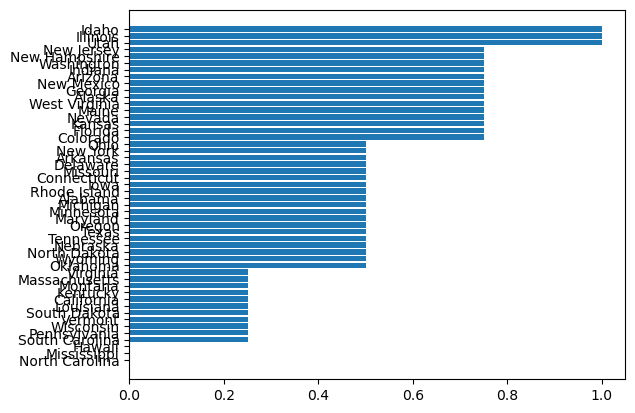

In [14]:
# your code here
# your code here
q = """
select state, 
(cast(avg(case when male > female then 1 else 0 end) as float)) as percentage
from math_gencompare
group by state
"""

df = pd.read_sql_query(q, cnx)

df = df.sort_values("percentage")

plt.barh(df.state, df.percentage)
plt.show()

## 2.6 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_vote` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list and using format. Hint you can use format and a joined list: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by that indicator and year and find the percencentage of states in each group where males had higher scores than females 

**C.** Read the results and interpret. Does early expansion of voting seem to be correlated with girls scoring bearing on the math tests a century later?

Hint: in order to group by the indicator in step b, you may need to use a subquery 

In [15]:
## we provide
list_voting = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]


In [80]:
## your code here
q = f"""select year, 
case when state in ({','.join(f"'{state}'" for state in list_voting)}) then 1 else 0 end as is_early_vote,
(cast(avg(case when male > female then 1 else 0 end) as float)) as perc
from math_gencompare
group by year, is_early_vote"""

df = pd.read_sql_query(q, cnx)
df

,year,is_early_vote,perc
0,2019,0,0.272727
1,2017,0,0.545455
2,2017,1,0.833333
3,2013,1,0.833333
4,2015,0,0.545455
5,2013,0,0.590909
6,2015,1,0.666667
7,2019,1,0.500000


In [82]:
np.corrcoef(df.is_early_vote, df.perc)

array([[1.        , 0.63894634],
       [0.63894634, 1.        ]])

There appears to be a negative correlation between whether a state had early expansion of voting and girls' scores on tests.

# 3. Pull state-level attributes using Census API (8 points)

You want to explain the variation you see across states in gender gaps in test scores by looking at demographics of the state population. To do so, we'll pull demographics from the American Community Survey (ACS), a US Census data product discussed more here: https://en.wikipedia.org/wiki/American_Community_Survey

## 3.1 Obtain a Census API key, place it in credentials yaml, load the yaml file, and initialize connection to Census API using the `census` package  (0 points)



In [17]:
# your code here
census = creds["CENSUS"]["API_KEY"]
c = Census(census)

## 3.2 Run this function (feeding it your api connection) to get a list of variables to pull (0 points)

Feed the connection to the API you created in previous step (if you print type it's a census.core.Census class) to the `your_connection` argument in the function)

In [18]:
## keep in blank
to_pull = ['RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS',
          'ALLOCATION OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS - PERCENT OF INCOME ALLOCATED',
          'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
          'EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER',
          'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP']

In [19]:
## keep in blank
def get_acs_varnames(your_connection):
    
    ## get tables for the acs 5-year estimates
    all_tables = pd.DataFrame(your_connection.acs5.tables())
    
    ## specify the ones to pull
    info_topull = all_tables[all_tables.description.isin(to_pull)].copy()
    
    ## use raw api to get varnames within those tables
    all_vars = [pd.DataFrame(requests.get(one_table).json()['variables']).T
                for one_table in info_topull.variables]
    all_vars_df = pd.concat(all_vars)
    all_vars_df['varname'] = all_vars_df.index
    
    ## subset to relevant
    all_vars_df_subset = all_vars_df[['varname', 'group', 'label', 'concept']].copy()
    all_vars_df_est = all_vars_df_subset[all_vars_df.varname.str.contains("E$", 
                                        regex = True)].copy()
    return(all_vars_df_est)
    

In [20]:
acs_cols = get_acs_varnames(c)
acs_cols.head()

,varname,group,label,concept
B17026_003E,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_004E,B17026_004E,B17026,Estimate!!Total:!!.75 to .99,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_001E,B17026_001E,B17026,Estimate!!Total:,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_002E,B17026_002E,B17026,Estimate!!Total:!!Under .50,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_007E,B17026_007E,B17026,Estimate!!Total:!!1.50 to 1.74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS


In [21]:
acs_cols.concept.nunique()

4

## 3.3 Pull the variables for all 50 states (8 points)

**A.** Use list comprehension to pull these variables for every state (each FIPS code) using the `acs5.state` method for the year 2013.
- Hint: See the documentation for how to feed it variables to pull (requires a tuple); the documentation shows an example state--`MD`. You can find the other `FIPS` codes for states in the `states` object in `us` package you loaded above): https://github.com/datamade/census/blob/70e2c08710c1e10e5bc2054b78613fa8794d4765/README.rst

**B.** Transform the result (which is a list of jsons) into a list of dataframes. Then concatenate and melt (on state) into one long-format dataframe

**C.** First merge with the `all_states_fips` df, then merge that with `acs_cols` from 3.2 (on varname and variable) to know both which states the variables correspond to and the more informative variable names 

Call the final output `acs_df_forperc` so you can run the next code we provide

In [22]:
## run this code- keep in blank
## NOTE: you need to have the us package
## installed and imported
cols_pull = tuple(acs_cols.varname)
all_states = states.STATES
all_states_fips = pd.DataFrame({'FIPS':
                                [one_state.fips for one_state in all_states],
                               'state': [one_state.name for one_state in all_states],
                               'abbrev': [one_state.abbr for one_state in all_states]})
all_states_fips.head()

,FIPS,state,abbrev
0,01,Alabama,AL
1,02,Alaska,AK
2,04,Arizona,AZ
3,05,Arkansas,AR
4,06,California,CA


In [23]:
# your code here
dfs = [c.acs5.state(cols_pull, state.fips, year=2013)[0] for state in states.STATES]
dfs = [pd.DataFrame(df, index=[0]) for df in dfs]
df = pd.concat(dfs)
df = df.melt(id_vars="state", value_vars=cols_pull)
df = df.merge(all_states_fips, left_on="state", right_on="FIPS", how="left")\
.merge(acs_cols, left_on="variable", right_on="varname", how="left")

In [24]:
acs_df_forperc = df.drop("state_x", axis=1).rename({"state_y": "state"})

In [25]:
acs_df_forperc

,variable,value,FIPS,state_y,abbrev,varname,group,label,concept
0,B17026_003E,50074.0,01,Alabama,AL,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
1,B17026_003E,3056.0,02,Alaska,AK,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
2,B17026_003E,55487.0,04,Arizona,AZ,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
3,B17026_003E,31249.0,05,Arkansas,AR,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
4,B17026_003E,292341.0,06,California,CA,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
...,...,...,...,...,...,...,...,...,...
3595,B09019_020E,32425.0,51,Virginia,VA,B09019_020E,B09019,Estimate!!Total:!!In households:!!Parent,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
3596,B09019_020E,31532.0,53,Washington,WA,B09019_020E,B09019,Estimate!!Total:!!In households:!!Parent,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
3597,B09019_020E,3701.0,54,West Virginia,WV,B09019_020E,B09019,Estimate!!Total:!!In households:!!Parent,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
3598,B09019_020E,11985.0,55,Wisconsin,WI,B09019_020E,B09019,Estimate!!Total:!!In households:!!Parent,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP


## 3.4 run code to transform counts into percentages (0 points)

- Run the following code to transform the ACS counts in `acs_df_forperc` into percentages

Note: You may see a warning from the str.split step; feel free to ignore it


In [26]:
def create_percentages(df, name_estimatecol = 'estimate'):
    
    ## remove cols that dont need percentages
    df_forperc = df[~df.perc_NA].copy()
    
    ## group by location and variable prefix 
    group_co_tract_varg = df_forperc.groupby(['FIPS', 'variable_prefix'])
    
    ## iterate over groups
    df_longperc = []
    for group, data_raw in group_co_tract_varg:
        prefix = data_raw.variable_prefix.iloc[0]
        FIPS = data_raw.FIPS.iloc[0]
        row_list_group = []
        data = data_raw.sort_values(by = 'variable_suffix')
        for i in range(1, data.shape[0]):
            numerator = data[name_estimatecol].iloc[i]
            denominator = float(data[name_estimatecol].iloc[0])
            if denominator == 0:
                denominator = np.nan
            if denominator != 0:
                percentage = numerator / denominator
                row = [prefix, FIPS]
                row = row + [data.variable_suffix.iloc[i], percentage]
                row_list_group.append(row)
        df_longperc.append(pd.DataFrame(row_list_group))
    percentages_all_groups = pd.concat(df_longperc)
    percentages_all_groups.columns = ['variable_prefix',"FIPS",
                                  'variable_suffix', 'percentage']
    percentages_all_groups['percentage'] = percentages_all_groups.percentage.astype(float)
    return(percentages_all_groups)



In [27]:
varnames_percnotrelevant = ["B19013_001E"]

## create prefix and suffix columns
acs_df_forperc['variable_prefix'], acs_df_forperc['variable_suffix'] = \
                                acs_df_forperc['varname'].str.split('_', 1).str
acs_df_forperc['perc_NA'] = np.where(acs_df_forperc.varname.isin(varnames_percnotrelevant),
                                  True, False)
acs_df_forperc = acs_df_forperc[acs_df_forperc.variable != "GEO_ID"].copy()

perc_long = create_percentages(acs_df_forperc, 'value').sort_values(by = 'variable_prefix')

In [28]:
perc_long_wnames = pd.merge(perc_long,
                           acs_df_forperc,
                           on = ['variable_prefix', 'variable_suffix', 'FIPS'],
                           how = "right")
perc_long_wnames['value'] = perc_long_wnames.value.astype(float)

perc_long_wnames['percentage'] = np.where(perc_long_wnames.perc_NA,
                                         perc_long_wnames.value,
                                         perc_long_wnames.percentage)
perc_long_wnames['varname_words'] = "acspredict_" + perc_long_wnames.concept.str.replace("\s+|\(|\)", "_", 
                                    regex = True).str.lower() + \
                            perc_long_wnames.label.str.replace("\.|\!|\,|\(|\)|\-", 
                                    "", regex = True).str.lower() 

perc_long_wnames_final = perc_long_wnames[['FIPS', 'percentage', 
                                          'varname_words']].copy()


perc_wide = pd.pivot_table(perc_long_wnames_final, 
                           index = 'FIPS',
                          columns='varname_words',
                            values='percentage').reset_index()

## merge state info back on
perc_wide_wstate = pd.merge(perc_wide,
                           all_states_fips,
                           on = "FIPS",
                           how = "left")


In [29]:
perc_wide_wstate.head()

,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:associate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:bachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:doctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:ged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:kindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:master's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:no schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:nursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:professional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:regular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in households:,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in household

## 3.5 extra credit (2 points)

Use list comprehension and NAEP query creation/process results functions you created above to iterate over state abbreviations in `all_states_fips` and pull the same test score gap information

If skipping, you'll read in pkl at next step

**Note**: this took 2 mins to run on my machine

In [30]:
# your code here

tmp_df = pd.concat([pd.read_json(json.dumps(construct_naep_query([2013, 2015, 2017, 2019], state).json()["result"]))
           for state in all_states_fips.abbrev]).reset_index()
wide_df = tmp_df.pivot_table(index="jurisdiction", columns=['varValueLabel', "year"],
                            values=['value']).reset_index().merge(perc_wide_wstate, left_on="jurisdiction", right_on="abbrev", how='left')

In [31]:
wide_df.columns = wide_df.columns.map(lambda t: "_".join([str(i) for i in t]) if type(t) == tuple else t)

# 4. Explore variation in math score disparities and trends (8 points)

## 4.0 If you didn't complete the extra credit, read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [32]:
## your code here

acs_df = pd.read_pickle("acs_wmath.pkl")

## 4.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


Text(0.5, 0, 'State')

Text(0, 0.5, 'Male Score - Female Score Disparity')

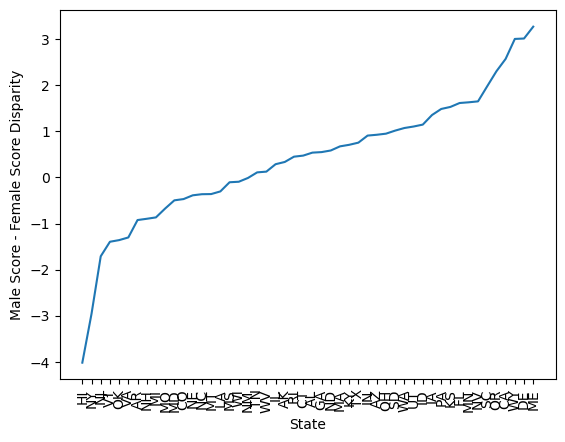

In [33]:
## your code here
wide_df["2013_disparity"] = wide_df.value_Male_2013 - wide_df.value_Female_2013
wide_df = wide_df.sort_values(by="2013_disparity")
plt.plot(wide_df.jurisdiction__, 
         wide_df.value_Male_2013 - wide_df.value_Female_2013)
plt.xlabel("State")
plt.ylabel("Male Score - Female Score Disparity")
_tmp = plt.xticks(rotation = 90)
plt.show()

## 4.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a smoothed scatterplot of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations:
   - Do boys in states with higher median household income (MHI) tend to perform better than boys in states with lower MHI?
   - Do girls in states with higher MHI tend to perform better than girls in states with lower MHI?
   - Is the male performance advantage over girls higher or lower in states with higher MHI?

In [34]:
acs_df["male_better_2013"] = np.where(acs_df.math_male_2013 > acs_df.math_female_2013, True, False)

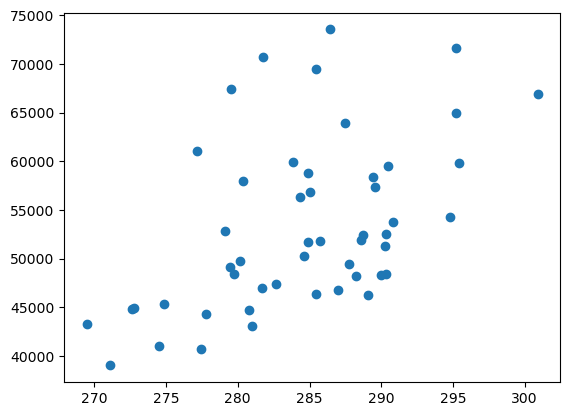

In [109]:
# your code here
from scipy.interpolate import make_interp_spline

acs_df = acs_df.sort_values("math_male_2013")

plt.scatter(acs_df.math_male_2013, 
            acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])

plt.show()

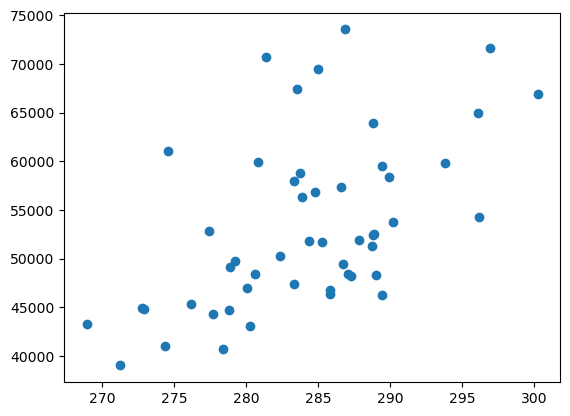

In [37]:
plt.scatter(acs_df.math_female_2013, acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
plt.show()

In [38]:
np.corrcoef(acs_df.math_male_2013, acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
np.corrcoef(acs_df.math_female_2013, acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
np.corrcoef(acs_df.male_better_2013, acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])

array([[1.        , 0.50734719],
       [0.50734719, 1.        ]])

array([[1.        , 0.54337803],
       [0.54337803, 1.        ]])

array([[ 1.       , -0.0338752],
       [-0.0338752,  1.       ]])

Boys in states with higher MHI tend to perform better than boys in states with lower MHI. Girls in states with higher MHI also tend to perform better than boys in states with lower MHI. The male performance advantage over girls is lower in states with higher MHI.